# DS-2.2 Baseline modeling pt.2

## **Description:**

Time to create wonders!! We are finally ready to produce our first ML model to meet customer requirements:
- Create your feature extraction step in accordance with our validation schema
- Intergrate your extraction algo into your validation class to ensure data leakage absence
- Create several ML models: 
    - Linear regression, SVR, Random Forest, XGBoost and play with them, find the best model and make your first submission

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import sys
sys.path.append('../')
from scripts.etl import transform_df_types
from scripts.baseline_modeling import TimeSeriesSplit, TrainModels # baseline_modeling.py module

# Load the train dataset with extracted features

In [2]:
train_df = pd.read_csv('../data/result_train.csv')
float_columns = train_df.select_dtypes(include=np.number).columns.tolist()
object_columns = train_df.select_dtypes(include=object).columns.tolist()

train_df = transform_df_types(train_df, int_columns=[], float_columns=float_columns, object_columns=object_columns)
train_df.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,...,item_cnt_month_cat_shop__lag_2,item_cnt_month_cat_shop__lag_3,days,avg_item_price,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_3,avg_item_price_lag_4,avg_item_price_lag_5,avg_item_price_lag_6
0,0.0,2.0,27.0,1.0,2499.0,0.0,0.0,"007 Legends [PS3, русская версия]",19.0,Игры - PS3,...,0.000000,0.000000,31.0,2325.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,17.0,2.0,27.0,1.0,498.0,5.0,1.0,"007 Legends [PS3, русская версия]",19.0,Игры - PS3,...,1.742424,1.970149,30.0,498.000000,498.000000,0.0,998.0,0.0,998.0,1048.0
2,2.0,2.0,30.0,1.0,359.0,2.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40.0,Кино - DVD,...,1.136364,0.000000,31.0,388.716522,382.645966,0.0,0.0,0.0,0.0,0.0


# Clean train set from unneeded columns

In [3]:
train = train_df.select_dtypes(include=np.number)
y = train['item_cnt_month']
X = train.drop(['item_cnt_month', 'item_price', 'revenue', 'avg_item_price'], axis=1, inplace=False)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608724 entries, 0 to 1608723
Data columns (total 30 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1608724 non-null  float32
 1   shop_id                         1608724 non-null  float32
 2   item_id                         1608724 non-null  float32
 3   month                           1608724 non-null  float32
 4   year                            1608724 non-null  float32
 5   item_category_id                1608724 non-null  float32
 6   months_since_last_sale          1608724 non-null  float32
 7   revenue_lag_1                   1608724 non-null  float32
 8   revenue_lag_2                   1608724 non-null  float32
 9   revenue_lag_3                   1608724 non-null  float32
 10  revenue_lag_6                   1608724 non-null  float32
 11  revenue_lag_12                  1608724 non-null  float32
 12  

# Get train and test set for further model analysis

In [6]:
tscv = TimeSeriesSplit(n_splits=1, method='expanding')

for train_idx, test_idx in tscv.split(X):
    X_new = X.copy()
    X_new.drop("date_block_num", axis=1, inplace=True)
    X_train, X_test = X_new[train_idx], X_new[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(1577193, 29) (1577193,)
(31531, 29) (31531,)


In [31]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Dummy regressor

In [26]:
from sklearn.dummy import DummyRegressor

def train_dummy_regressor(X, y, dummy_strategy='median', cv_method="expanding", cv_n_splits=5, return_scores=False, return_model=False):
    """
    Returns on of these:
        - None
        - model
        - scores
        - model, scores
    """

    scores = []
    tscv = TimeSeriesSplit(n_splits=cv_n_splits, method=cv_method)

    for train_idx, test_idx in tscv.split(X):
        X_new = X.copy()
        X_new.drop("date_block_num", axis=1, inplace=True)
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = DummyRegressor(strategy=dummy_strategy)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred = y_pred.clip(0, 20)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)

        print(f"{len(scores)} split RMSE: {score:.2f}\n")

    print(f"Average RMSE: {np.mean(scores):.2f}")

    if return_scores or return_model:
        to_return = []
        if return_model:
            to_return.append(model)
        if return_scores:
            to_return.append(scores)
        return tuple(to_return)

In [27]:
dummy = train_dummy_regressor(X, y, dummy_strategy='median', cv_method="expanding", cv_n_splits=5, return_model=True)

1 split RMSE: 2.38

2 split RMSE: 2.15

3 split RMSE: 2.25

4 split RMSE: 2.73

5 split RMSE: 2.71

Average RMSE: 2.44


In [ ]:
def plot_actual_vs_predicted(y_true, y_pred, model_name="Model"):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, s=5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.show()

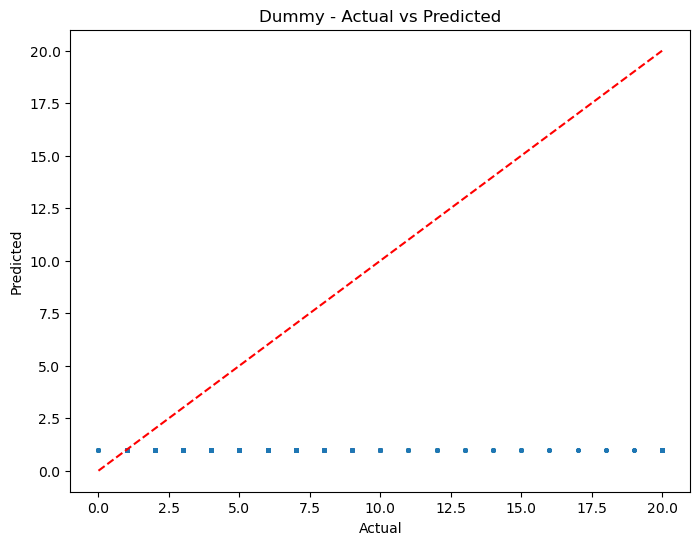

In [ ]:
y_pred = dummy[0].predict(X_test)
plot_actual_vs_predicted(y_test, y_pred, model_name="Dummy")

# Linear regression

In [22]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [28]:
def train_linear_regression(X, y, regularization=None, alpha=0.1, scaler=StandardScaler(), cv_method="expanding", cv_n_splits=5, return_scores=False, return_model=False):
    """
    Returns on of these:
        - None
        - model
        - scores
        - model, scores
    """

    scores = []
    tscv = TimeSeriesSplit(n_splits=cv_n_splits, method=cv_method)

    for train_idx, test_idx in tscv.split(X):
        X_new = X.copy()
        X_new.drop("date_block_num", axis=1, inplace=True)
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if scaler is not None:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        if regularization is None:
            model = LinearRegression()
        elif regularization == 'lasso':
            model = Lasso(alpha=alpha)
        elif regularization == 'ridge':
            model = Ridge(alpha=alpha)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred = y_pred.clip(0, 20)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)

        print(f"{len(scores)} split RMSE: {score:.2f}\n")

    print(f"Average RMSE: {np.mean(scores):.2f}")

    if return_scores or return_model:
        to_return = []
        if return_model:
            to_return.append(model)
        if return_scores:
            to_return.append(scores)
        return tuple(to_return)

In [29]:
lr = train_linear_regression(X, y, scaler=StandardScaler(), return_model=True)

1 split RMSE: 1.76

2 split RMSE: 1.52

3 split RMSE: 1.63

4 split RMSE: 2.13

5 split RMSE: 2.23

Average RMSE: 1.85


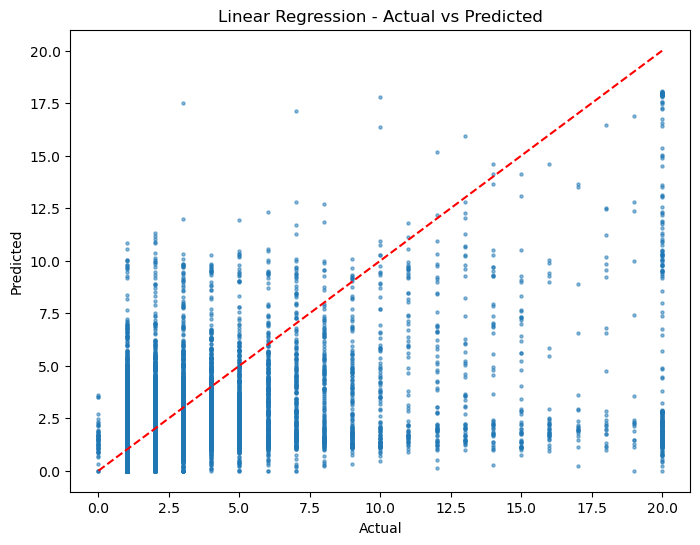

In [32]:
y_pred = lr[0].predict(X_test_scaled)
y_pred = y_pred.clip(0, 20)
plot_actual_vs_predicted(y_test, y_pred, model_name="Linear Regression")

In [33]:
lasso = train_linear_regression(X, y, regularization='lasso', scaler=StandardScaler(), alpha=0.5, return_model=True)

1 split RMSE: 1.87

2 split RMSE: 1.65

3 split RMSE: 1.77

4 split RMSE: 2.26

5 split RMSE: 2.30

Average RMSE: 1.97


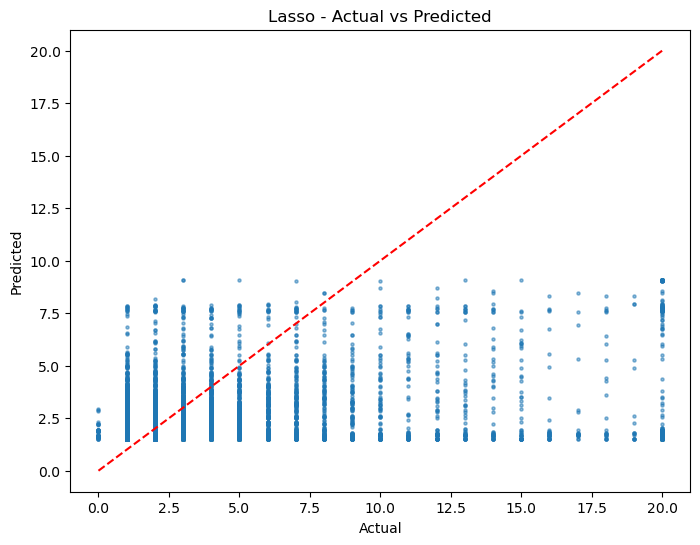

In [34]:
y_pred = lasso[0].predict(X_test_scaled)
y_pred = y_pred.clip(0, 20)
plot_actual_vs_predicted(y_test, y_pred, model_name="Lasso")

In [35]:
ridge = train_linear_regression(X, y, regularization='ridge', scaler=StandardScaler(), alpha=0.5, return_model=True)

1 split RMSE: 1.76

2 split RMSE: 1.52

3 split RMSE: 1.63

4 split RMSE: 2.14

5 split RMSE: 2.23

Average RMSE: 1.85


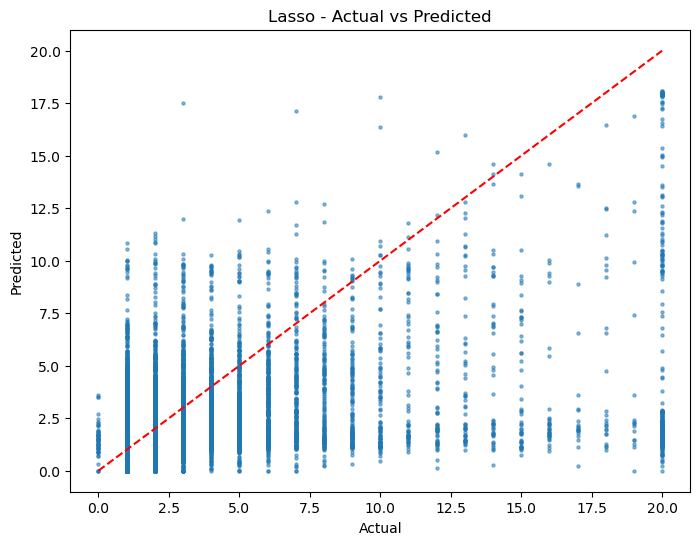

In [ ]:
y_pred = ridge[0].predict(X_test_scaled)
y_pred = y_pred.clip(0, 20)
plot_actual_vs_predicted(y_test, y_pred, model_name="Ridge")

# Support Vector Regression

In [37]:
from sklearn.svm import LinearSVR

In [41]:
def train_svr(X, y, C=1, epsilon=0.1, scaler=StandardScaler(), cv_method="expanding", cv_n_splits=1, return_scores=False, return_model=False):
    """
    Returns on of these:
        - None
        - model
        - scores
        - model, scores
    """

    scores = []
    tscv = TimeSeriesSplit(n_splits=cv_n_splits, method=cv_method)

    for train_idx, test_idx in tscv.split(X):
        X_new = X.copy()
        X_new.drop("date_block_num", axis=1, inplace=True)
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if scaler is not None:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        model = LinearSVR(C=C, epsilon=epsilon)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred = y_pred.clip(0, 20)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)

        print(f"{len(scores)} split RMSE: {score:.2f}\n")

    print(f"Average RMSE: {np.mean(scores):.2f}")

    if return_scores or return_model:
        to_return = []
        if return_model:
            to_return.append(model)
        if return_scores:
            to_return.append(scores)
        return tuple(to_return)

In [ ]:
train_svr(X, y, C=1, epsilon=0.1, scaler=StandardScaler())

/home/alexennk/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


1 split RMSE: 2.32

Average RMSE: 2.32


/home/alexennk/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVR required 9 minutes of training with linear kernel and 1 validation split..

# Random Forest Regressor

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [50]:
def train_rfr(X, y, max_depth=15, n_estimators=100, min_samples_leaf=5, random_state=42, scaler=StandardScaler(), cv_method="expanding", cv_n_splits=1, train_start=0, return_scores=False, return_model=False):
    """
    Returns on of these:
        - None
        - model
        - scores
        - model, scores
    """

    scores = []
    tscv = TimeSeriesSplit(n_splits=cv_n_splits, method=cv_method, train_start=train_start)

    for train_idx, test_idx in tscv.split(X):
        X_new = X.copy()
        X_new.drop("date_block_num", axis=1, inplace=True)
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if scaler is not None:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=random_state, n_jobs=-1)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred = y_pred.clip(0, 20)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)

        print(f"{len(scores)} split RMSE: {score:.2f}\n")

    print(f"Average RMSE: {np.mean(scores):.2f}")

    if return_scores or return_model:
        to_return = []
        if return_model:
            to_return.append(model)
        if return_scores:
            to_return.append(scores)
        return tuple(to_return)

In [51]:
rfr = train_rfr(X, y, max_depth=17, n_estimators=100, min_samples_leaf=5, random_state=42, train_start=12, return_model=True)

1 split RMSE: 1.98

Average RMSE: 1.98


In [ ]:
pickle.dump(rfr[0], open("../models/rfr.pkl", "wb"))
rfr = pickle.load(open("../models/rfr.pkl", "rb"))

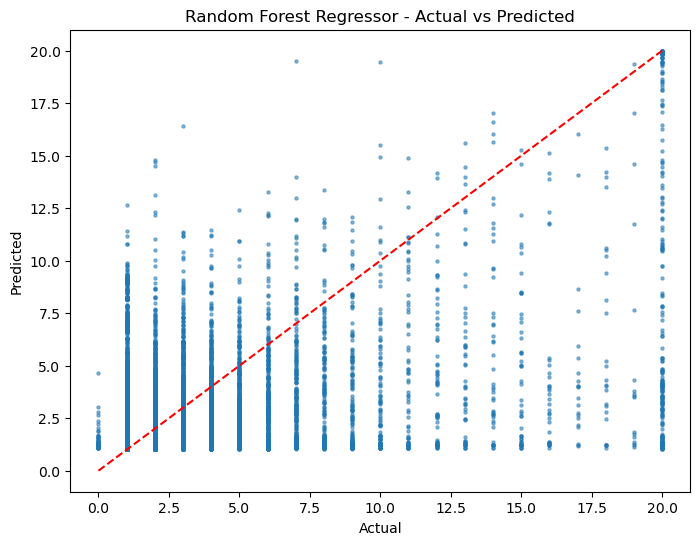

In [54]:
y_pred = rfr[0].predict(X_test_scaled)
y_pred = y_pred.clip(0, 20)
plot_actual_vs_predicted(y_test, y_pred, model_name="Random Forest Regressor")

# CatBoost

In [56]:
from catboost import CatBoostRegressor

In [109]:
def train_catboost(X, y, scaler=StandardScaler(), cv_method="expanding", cv_n_splits=5, train_start=0, return_scores=False, return_model=False):
    """
    Returns on of these:
        - None
        - model
        - scores
        - model, scores
    """

    scores = []
    tscv = TimeSeriesSplit(n_splits=cv_n_splits, method=cv_method, train_start=train_start)

    for train_idx, test_idx in tscv.split(X):
        X_new = X.copy()
        X_new.drop("date_block_num", axis=1, inplace=True)
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if scaler is not None:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        model = CatBoostRegressor(iterations=1500, learning_rate=0.05,eval_metric='RMSE')

        model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=False)

        y_pred = model.predict(X_test)
        y_pred = y_pred.clip(0, 20)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)

        print(f"{len(scores)} split RMSE: {score:.2f}\n")

    print(f"Average RMSE: {np.mean(scores):.2f}")

    if return_scores or return_model:
        to_return = []
        if return_model:
            to_return.append(model)
        if return_scores:
            to_return.append(scores)
        return tuple(to_return)

In [110]:
catboost_model = train_catboost(X, y, scaler=None, cv_n_splits=1, return_model=True)

0:	learn: 2.5354812	test: 2.5010072	best: 2.5010072 (0)	total: 80.5ms	remaining: 2m
1:	learn: 2.4950644	test: 2.4673846	best: 2.4673846 (1)	total: 166ms	remaining: 2m 4s
2:	learn: 2.4574661	test: 2.4362130	best: 2.4362130 (2)	total: 268ms	remaining: 2m 13s
3:	learn: 2.4231579	test: 2.4075878	best: 2.4075878 (3)	total: 353ms	remaining: 2m 11s
4:	learn: 2.3911427	test: 2.3813282	best: 2.3813282 (4)	total: 450ms	remaining: 2m 14s
5:	learn: 2.3619241	test: 2.3574885	best: 2.3574885 (5)	total: 529ms	remaining: 2m 11s
6:	learn: 2.3346718	test: 2.3357864	best: 2.3357864 (6)	total: 615ms	remaining: 2m 11s
7:	learn: 2.3094303	test: 2.3169982	best: 2.3169982 (7)	total: 702ms	remaining: 2m 10s
8:	learn: 2.2863242	test: 2.2994098	best: 2.2994098 (8)	total: 784ms	remaining: 2m 9s
9:	learn: 2.2646953	test: 2.2821892	best: 2.2821892 (9)	total: 887ms	remaining: 2m 12s
10:	learn: 2.2454470	test: 2.2668668	best: 2.2668668 (10)	total: 988ms	remaining: 2m 13s
11:	learn: 2.2268471	test: 2.2530839	best: 2.2

In [59]:
catboost_model[0].save_model("../models/catboost_model_untuned.cbm")

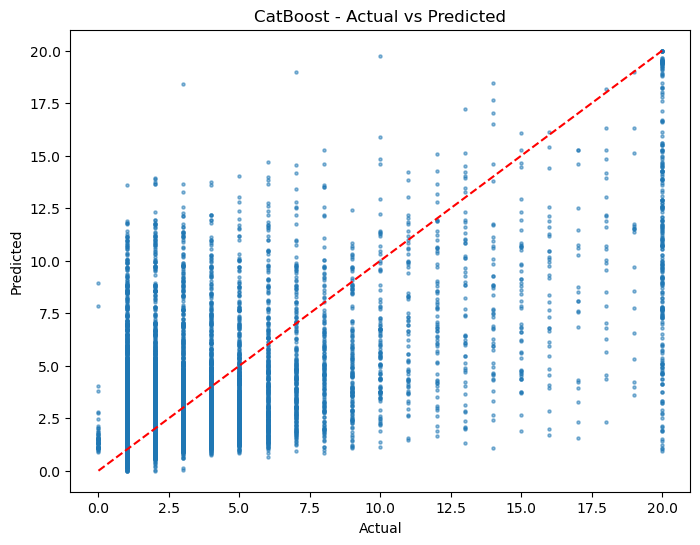

In [64]:
y_pred = catboost_model[0].predict(X_test)
y_pred = y_pred.clip(0, 20)
plot_actual_vs_predicted(y_test, y_pred, model_name="CatBoost")

In [63]:
catboost_model_12 = train_catboost(X, y, scaler=None, cv_n_splits=1, train_start=12, return_model=True)

Learning rate set to 0.119714
0:	learn: 2.4155857	total: 86.8ms	remaining: 1m 26s
1:	learn: 2.3248535	total: 175ms	remaining: 1m 27s
2:	learn: 2.2494808	total: 269ms	remaining: 1m 29s
3:	learn: 2.1878885	total: 357ms	remaining: 1m 28s
4:	learn: 2.1379292	total: 447ms	remaining: 1m 28s
5:	learn: 2.0956242	total: 548ms	remaining: 1m 30s
6:	learn: 2.0618648	total: 635ms	remaining: 1m 30s
7:	learn: 2.0328035	total: 724ms	remaining: 1m 29s
8:	learn: 2.0087726	total: 810ms	remaining: 1m 29s
9:	learn: 1.9870692	total: 893ms	remaining: 1m 28s
10:	learn: 1.9705331	total: 971ms	remaining: 1m 27s
11:	learn: 1.9557730	total: 1.06s	remaining: 1m 27s
12:	learn: 1.9420154	total: 1.15s	remaining: 1m 27s
13:	learn: 1.9315632	total: 1.2s	remaining: 1m 24s
14:	learn: 1.9217734	total: 1.25s	remaining: 1m 22s
15:	learn: 1.9148422	total: 1.3s	remaining: 1m 19s
16:	learn: 1.9071638	total: 1.35s	remaining: 1m 17s
17:	learn: 1.9008839	total: 1.4s	remaining: 1m 16s
18:	learn: 1.8932989	total: 1.46s	remaining: 1

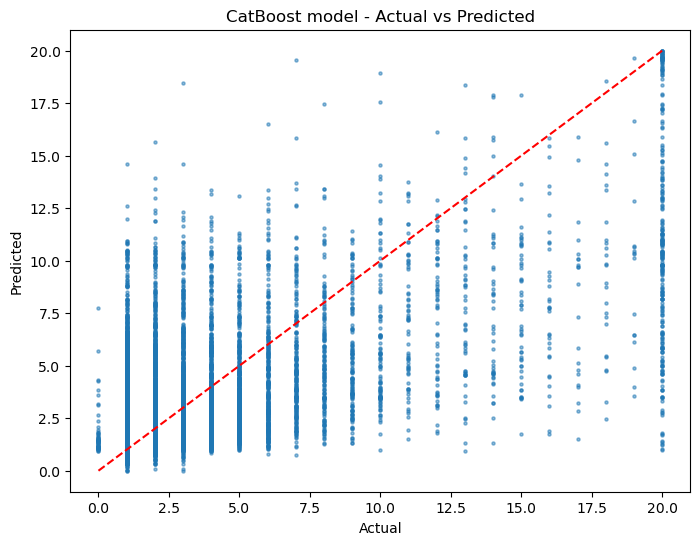

In [66]:
y_pred = catboost_model_12[0].predict(X_test)
y_pred = y_pred.clip(0, 20)
plot_actual_vs_predicted(y_test, y_pred, model_name="CatBoost model")

In [78]:
def plot_residuals(y_true, y_pred, model_name="Model"):
    residuals = y_true - y_pred
    plt.figure(figsize=(7, 4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"{model_name} - Residual Plot")
    plt.show()

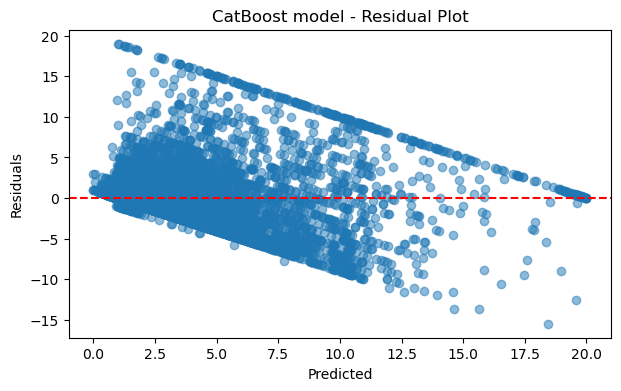

In [79]:
plot_residuals(y_test, y_pred, model_name="CatBoost model")

In [80]:
def plot_residual_distribution(y_true, y_pred, model_name="Model"):
    residuals = y_true - y_pred
    plt.figure(figsize=(7, 4))
    sns.histplot(residuals, color="blue")
    plt.xlabel("Residuals")
    plt.title(f"{model_name} - Residual Distribution")
    plt.show()

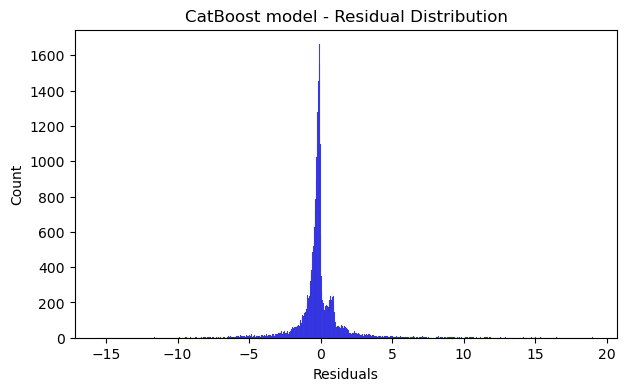

In [81]:
plot_residual_distribution(y_test, y_pred, model_name="CatBoost model")

In [111]:
eval_history = catboost_model[0].get_evals_result()

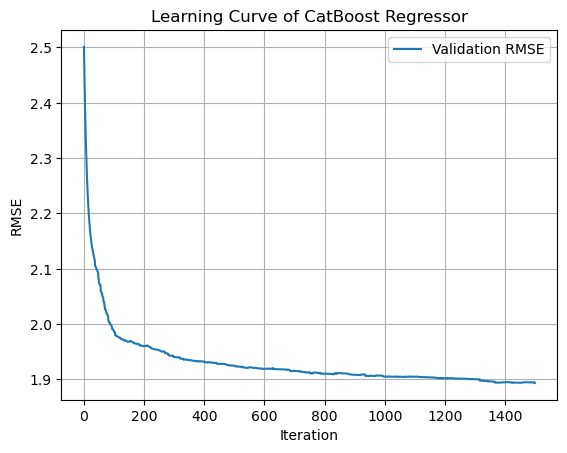

In [112]:
# Plot learning curve
plt.plot(eval_history['validation']['RMSE'], label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Learning Curve of CatBoost Regressor')
plt.legend()
plt.grid()
plt.show()

### Negative residuals appear more often ==> the model tends to predict values that are bigger than in reality

# Function for creating submission

### Load the test set

In [17]:
test = pd.read_csv("../data/result_test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              214200 non-null  int64  
 1   shop_id                         214200 non-null  int64  
 2   item_id                         214200 non-null  int64  
 3   item_name                       214200 non-null  object 
 4   item_category_id                214200 non-null  int64  
 5   item_category_name              214200 non-null  object 
 6   shop_name                       214200 non-null  object 
 7   months_since_last_sale          214200 non-null  int64  
 8   revenue_lag_1                   214200 non-null  float64
 9   revenue_lag_2                   214200 non-null  float64
 10  revenue_lag_3                   214200 non-null  float64
 11  revenue_lag_6                   214200 non-null  float64
 12  revenue_lag_12  

In [29]:
def get_submission(model, test, scaler=None, rounding=False, submission_tag=""):
    test_id = test["ID"]
    test = test.drop(["ID", "item_name", "shop_name", "item_category_name"], axis=1)

    if scaler is not None:
        test = scaler.transform(test)

    y_pred = model.predict(test)

    if rounding:
        y_pred = y_pred.round()
        
    y_pred = y_pred.clip(0, 20)

    submission = pd.DataFrame({"ID": test_id, "item_cnt_month": y_pred})
    submission.to_csv("submission_" + submission_tag + ".csv", index=False)